In [65]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


Now load each Data csv Players and ranking is pretty straight forward

## All ATP Players 

Note alot of the DOB columns data is missing 27%
Alot of Height is also missing 90% 

-----

We will do the cleaning / imputing for these values when we look at the matches csv

In [66]:
players = pd.read_csv('../data/raw/atp_players.csv')
print(f"loaded successfully {len(players)} players ")
print(f"\nColumns: {list(players.columns)}")
print(f"\nFirst few rows:")
print(players.head())
print(players.info())

print("==="*10)

missing_count = players.isnull().sum()
missing_percentage = (players.isnull().sum() / len(players)) * 100
#print(f"\nMissing values:")
#print(missing_count)
print(f"\nMissing percentage:")
print(missing_percentage)





loaded successfully 65989 players 

Columns: ['player_id', 'name_first', 'name_last', 'hand', 'dob', 'ioc', 'height', 'wikidata_id']

First few rows:
   player_id name_first name_last hand         dob  ioc  height wikidata_id
0     100001    Gardnar    Mulloy    R  19131122.0  USA   185.0      Q54544
1     100002     Pancho    Segura    R  19210620.0  ECU   168.0      Q54581
2     100003      Frank   Sedgman    R  19271002.0  AUS   180.0     Q962049
3     100004   Giuseppe     Merlo    R  19271011.0  ITA     NaN    Q1258752
4     100005    Richard  Gonzalez    R  19280509.0  USA   188.0      Q53554
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65989 entries, 0 to 65988
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   player_id    65989 non-null  int64  
 1   name_first   65068 non-null  object 
 2   name_last    65941 non-null  object 
 3   hand         65973 non-null  object 
 4   dob          47587 non-null  

## Loading the Rankings + Analyzing the data 


Currently doing for Rankings current 2024:

No null values, looks like the rankings are redone every week or so based on new matches done so basically in the matches data we have the same thing already merged by weekly updates so it explains why some players have it as Blanks because they don't have a rank or ranking points - Impute it with the max value + 1  #### this is Potentially where an ELO system could help so the players that don't have Ranking points or rankings can have that being used to predict - But will need to have elo ratings calculated per week and then replace them into the system / data with the updated elo for that week ####

Also note there are about ~2050 rankings per week give or take because if a person doesn't play a match in the past 52 weeks they get all their points removed and they sit at 0 and maybe those are the players that don't show up as any rank points / rank so we should replace those ranks with the max rank + 1 basically and rank points set it as 0 

#### Technically don't need to do anything apart from this because this data is essentially already loaded with the matches data

In [67]:
# Cell 4: Load Rankings
rankings = pd.read_csv('../data/raw/atp_rankings_current.csv')
print(f"✓ Loaded {len(rankings):,} ranking records")
print(f"\nColumns: {list(rankings.columns)}")
print(f"\nDate range: {rankings['ranking_date'].min()} to {rankings['ranking_date'].max()}")

print(rankings.head())
print(rankings.info())
#print(rankings.isnull().sum() ) # no Null values 



✓ Loaded 92,341 ranking records

Columns: ['ranking_date', 'rank', 'player', 'points']

Date range: 20240101 to 20241230
   ranking_date  rank  player  points
0      20240101     1  104925   11245
1      20240101     2  207989    8855
2      20240101     3  106421    7600
3      20240101     4  206173    6490
4      20240101     5  126094    4805
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92341 entries, 0 to 92340
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ranking_date  92341 non-null  int64
 1   rank          92341 non-null  int64
 2   player        92341 non-null  int64
 3   points        92341 non-null  int64
dtypes: int64(4)
memory usage: 2.8 MB
None


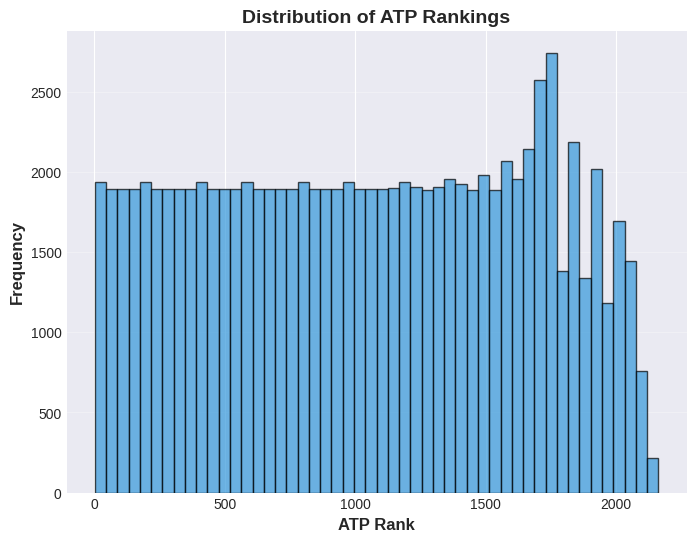

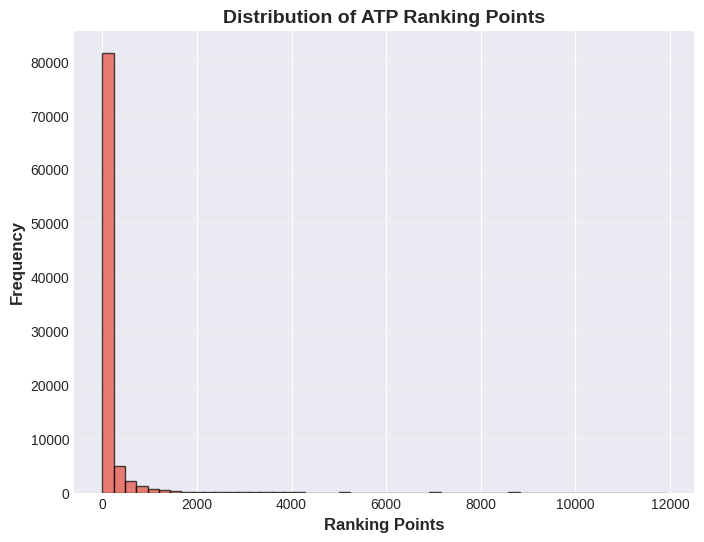

In [68]:
# Plotting Rankings

# Show distribution of all rankings
plt.figure(figsize=(8, 6))
plt.hist(rankings['rank'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
plt.xlabel('ATP Rank', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Distribution of ATP Rankings', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(rankings['points'].dropna(), bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
plt.xlabel('Ranking Points', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Distribution of ATP Ranking Points', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()

## Load The Tour Matches 

Currently thinking that we should only do the 2014-2024 matches ( Official + Qualification Only)
* Training Data: 2014-2022
* Validation: 2023
* Test: 2024


--------
### TODO LATER :

* One slight mis calculation, Our Integer based dates are luckly in YYYYMMDD format but could have a been a mess and could potentially still load them in date time 

### 📅 Date Format Consideration

**Current Format:** Integer dates in YYYYMMDD format (e.g., 20140101)

✓ Works correctly for sorting and comparisons (`>`, `<`, `==`)  
✗ Limited for feature engineering (extracting month, day-of-week, calculating days between matches)

---

**TODO:** Convert to datetime for better temporal feature engineering:
```python
matches['tourney_date'] = pd.to_datetime(matches['tourney_date'], format='%Y%m%d')
```

**Benefits of datetime:**
- Easy extraction: `.dt.year`, `.dt.month`, `.dt.dayofweek`, `.dt.quarter`
- Date arithmetic: days between matches, rolling time windows
- Time-based filtering: last N days, date ranges
- Cleaner, more readable code for temporal features

In [69]:
# Cell 5: Load Main Tour Matches (2018-2024 as recommended)
import os

years = range(2010, 2025)  # 2020-2024
match_files = [f'../data/raw/atp_matches_{year}.csv' for year in years]
qualification_files = [f'../data/raw/atp_matches_qual_chall_{year}.csv' for year in years]

# Load and concatenate
# Qualifying_match = 0 ( for sparsity )
dfs = []
for file in match_files:
    if os.path.exists(file):
        df = pd.read_csv(file, low_memory=False)
        df['Qualifying_match'] = 0  # Flag for main ATP
        print(f"✓ Loaded {file.split('/')[-1]}: {len(df):,} matches")
        dfs.append(df)


for file in qualification_files:
    if os.path.exists(file):
        df = pd.read_csv(file, low_memory=False)
        df['Qualifying_match'] = 1  # Flag for main ATP
        print(f"✓ Loaded {file.split('/')[-1]}: {len(df):,} matches")
        dfs.append(df)

matches = pd.concat(dfs, ignore_index=True)

print(f"\n{'='*70}")
print(f"TOTAL MAIN TOUR MATCHES (Qualification and Main ATP matches ) (2014-2024): {len(matches):,}")
print(f"{'='*70}")

#print(matches.head())
print("Number of null values in matches data in %age")
print(matches.isnull().sum() / len(matches) * 100)
#print(matches.info())

✓ Loaded atp_matches_2010.csv: 3,030 matches
✓ Loaded atp_matches_2011.csv: 3,015 matches
✓ Loaded atp_matches_2012.csv: 3,009 matches
✓ Loaded atp_matches_2013.csv: 2,944 matches
✓ Loaded atp_matches_2014.csv: 2,901 matches
✓ Loaded atp_matches_2015.csv: 2,943 matches
✓ Loaded atp_matches_2016.csv: 2,941 matches
✓ Loaded atp_matches_2017.csv: 2,911 matches
✓ Loaded atp_matches_2018.csv: 2,897 matches
✓ Loaded atp_matches_2019.csv: 2,806 matches
✓ Loaded atp_matches_2020.csv: 1,462 matches
✓ Loaded atp_matches_2021.csv: 2,733 matches
✓ Loaded atp_matches_2022.csv: 2,917 matches
✓ Loaded atp_matches_2023.csv: 2,986 matches
✓ Loaded atp_matches_2024.csv: 3,076 matches
✓ Loaded atp_matches_qual_chall_2010.csv: 6,597 matches
✓ Loaded atp_matches_qual_chall_2011.csv: 6,371 matches
✓ Loaded atp_matches_qual_chall_2012.csv: 6,426 matches
✓ Loaded atp_matches_qual_chall_2013.csv: 6,464 matches
✓ Loaded atp_matches_qual_chall_2014.csv: 6,424 matches
✓ Loaded atp_matches_qual_chall_2015.csv: 6,8

## A.Removing the columns / Features we don't need for model training / wont have during the test time / OR are redudant / High level of missingness

Note: We would have winners and losers but effectively it would be the player 0 and player 1 ( will have to do that in the next part)
#### Removing following columns
1. Winner_seed and Loser_Seed drop because it is basically same as rank
2. Tournament_ID , match_num Because they are Identifying each row uniquely we are trying to generalize not memorize 
3. ( Keep for now ) Winner_name and Loser_name because cause over fitting 
4.  Score, minutes and all of the w_ace and w_* + l_* columns since they are all 
5. Tournament Name b/c its another needless column that indentifies rows 

#### Keeping:
1. Tourney_level because it states the prestiege 
2. Winner_entry because from the research I did the NaN values are actualy Direction entrants i.e people that automatically got entered because of high Atp points / ranking
3. (Drop later ? )Winner_id and Loser_ID for and Feature engineering then drop I believe 
4. Winner and loser hieght despite being 9% missing , we can impute by location of player and mean / check if its mentioned in other areas
5. ( Drop later ? ) Tournament date - Need for feature engineering


In [70]:
print("="*70)
print("DROPPING UNNECESSARY COLUMNS")
print("="*70)

# Define columns to drop with reasons
columns_to_drop = []

# 1. Seed columns (redundant with rank)
seed_cols = ['winner_seed', 'loser_seed']
columns_to_drop.extend(seed_cols)
print(f"\n1. DROPPING SEED COLUMNS (redundant with rank):")
print(f"   {seed_cols}")

# 2. Identifier columns (unique row identifiers)
id_cols = ['tourney_id', 'match_num', 'tourney_name']
columns_to_drop.extend(id_cols)
print(f"\n2. DROPPING IDENTIFIER COLUMNS (not generalizable):")
print(f"   {id_cols}")

# 3. Keep winner_name and loser_name for now (noted in comments)
print(f"\n3. KEEPING NAME COLUMNS (for now, may drop later):")
print(f"   ['winner_name', 'loser_name']")

# 4. Match outcome columns (information leakage)
outcome_cols = ['score', 'minutes']
columns_to_drop.extend(outcome_cols)
print(f"\n4. DROPPING MATCH OUTCOME COLUMNS (information leakage):")
print(f"   {outcome_cols}")

# 5. All match statistics (w_* and l_* columns)
stat_cols = [col for col in matches.columns if col.startswith('w_') or col.startswith('l_')]
columns_to_drop.extend(stat_cols)
print(f"\n5. DROPPING MATCH STATISTICS (information leakage):")
print(f"   Found {len(stat_cols)} stat columns: {stat_cols[:5]}... (and {len(stat_cols)-5} more)")

# Summary
print(f"\n{'='*70}")
print(f"SUMMARY")
print(f"{'='*70}")
print(f"Total columns to drop: {len(columns_to_drop)}")
print(f"Original columns: {len(matches.columns)}")
print(f"Remaining columns: {len(matches.columns) - len(columns_to_drop)}")

# Drop the columns
matches_cleaned = matches.drop(columns=columns_to_drop)

print(f"\n{'='*70}")
print(f"CLEANED DATASET")
print(f"{'='*70}")
print(f"Shape: {matches_cleaned.shape}")
print(f"\nRemaining columns ({len(matches_cleaned.columns)}):")

print("Number of null values in matches cleaned data in %age")
print(matches_cleaned.isnull().sum() / len(matches_cleaned) * 100)

#### Save the cleaned data 
matches_cleaned.to_csv('../data/processed/matches_cleaned_columns_dropped.csv', index=False)




DROPPING UNNECESSARY COLUMNS

1. DROPPING SEED COLUMNS (redundant with rank):
   ['winner_seed', 'loser_seed']

2. DROPPING IDENTIFIER COLUMNS (not generalizable):
   ['tourney_id', 'match_num', 'tourney_name']

3. KEEPING NAME COLUMNS (for now, may drop later):
   ['winner_name', 'loser_name']

4. DROPPING MATCH OUTCOME COLUMNS (information leakage):
   ['score', 'minutes']

5. DROPPING MATCH STATISTICS (information leakage):
   Found 18 stat columns: ['w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon']... (and 13 more)

SUMMARY
Total columns to drop: 25
Original columns: 50
Remaining columns: 25

CLEANED DATASET
Shape: (162285, 25)

Remaining columns (25):
Number of null values in matches cleaned data in %age
surface                0.032659
draw_size              0.000000
tourney_level          0.000000
tourney_date           0.000000
winner_id              0.000000
winner_entry          85.636380
winner_name            0.000000
winner_hand            0.000000
winner_ht              4.

## B. Cleaning the Data in the remaining columns

remove the rows that are missing or , impute and set flag ( where required )

### 1. Deal with the Surface .0425% missing 

*  We can try to impute with the most occuring values of the surface type on that tournament_ID / Name - Couldn't because that tournament has multiple values from past historical data 

* Ended up dropping those 53 null rows since its so miniscule any ways

In [71]:
print(matches_cleaned.shape)
# Drop rows with missing surface
matches_cleaned = matches_cleaned.dropna(subset=['surface'])
print(matches_cleaned.shape)
#print("Number of null values in matches data in %age")
#print(matches_cleaned.isnull().sum() / len(matches_cleaned) * 100)



(162285, 25)
(162232, 25)


### 2. Deal with The winner and loser entry 84% for winners vs 73% for loosers ~  missing. 

Types of entries: - 'WC' = wild card, 'Q' = qualifier, 'LL' = lucky loser, 'PR' = protected ranking, 'ITF' = ITF entry, and there are a few others that are occasionally used.

For People that are automatically qualified for the tournament through the rankings they are "Direct" entries and in the data set are mentioned as Null so we can impute 

* No need for flags because Use a flag only when the imputed value is uncertain —
that is, when you’re guessing rather than knowing what the missing value means.

In [72]:
# Replace NaN values in entry columns with 'Direct'
matches_cleaned['winner_entry'] = matches_cleaned['winner_entry'].fillna('Direct')
matches_cleaned['loser_entry'] = matches_cleaned['loser_entry'].fillna('Direct')

#print(f"Winner entry value counts:\n{matches_cleaned['winner_entry'].value_counts()}")
#print(f"\nLoser entry value counts:\n{matches_cleaned['loser_entry'].value_counts()}")
print(matches_cleaned.shape)

print(matches_cleaned.isnull().sum() / len(matches_cleaned) * 100)


(162232, 25)
surface                0.000000
draw_size              0.000000
tourney_level          0.000000
tourney_date           0.000000
winner_id              0.000000
winner_entry           0.000000
winner_name            0.000000
winner_hand            0.000000
winner_ht              4.599586
winner_ioc             0.000000
winner_age             0.006780
loser_id               0.000000
loser_entry            0.000000
loser_name             0.000000
loser_hand             0.006780
loser_ht              10.143498
loser_ioc              0.000616
loser_age              0.071503
best_of                0.000000
round                  0.000000
winner_rank            0.782830
winner_rank_points     0.791459
loser_rank             3.174466
loser_rank_points      3.183712
Qualifying_match       0.000000
dtype: float64


### 3. Deal with Winner and Loser Height

* [ NO GO DIDN'T WORK  ] First lets try to see if the same player has height mentioned some where else: winner_ht (4.30% NA), loser_ht (9.00% NA): impute per-player median height by merging across that player’s other matches via ID; height is player-constant. - 

* -->[ WENT WITH THIS ] If still NA, impute global median by Location of the player

    * still had some remaining so I removed those approx 200 

* ##### Optional add a Flag 
    Minimal features to add : winner_is_height_proxy, loser_is_height_proxy (1 only when IOC/global fallback used)

In [73]:
# Calculate median height by country for winners
winner_ht_by_country = matches_cleaned.groupby('winner_ioc')['winner_ht'].median()

# Calculate median height by country for losers
loser_ht_by_country = matches_cleaned.groupby('loser_ioc')['loser_ht'].median()


# Combine to get overall country median heights
country_heights = pd.concat([winner_ht_by_country, loser_ht_by_country]).groupby(level=0).median()


# Fill missing winner_ht with country median
missing_winner_before = matches_cleaned['winner_ht'].isnull().sum()
matches_cleaned['winner_ht'] = matches_cleaned['winner_ht'].fillna(
    matches_cleaned['winner_ioc'].map(country_heights)
)

# Fill missing loser_ht with country median
missing_loser_before = matches_cleaned['loser_ht'].isnull().sum()
matches_cleaned['loser_ht'] = matches_cleaned['loser_ht'].fillna(
    matches_cleaned['loser_ioc'].map(country_heights)
)

# Check results
filled_winner = missing_winner_before - matches_cleaned['winner_ht'].isnull().sum()
filled_loser = missing_loser_before - matches_cleaned['loser_ht'].isnull().sum()

print(f"Winner height - Filled by country: {filled_winner}, Still missing: {matches_cleaned['winner_ht'].isnull().sum()}")
print(f"Loser height - Filled by country: {filled_loser}, Still missing: {matches_cleaned['loser_ht'].isnull().sum()}")

# Remove remaining rows with missing height
matches_cleaned = matches_cleaned.dropna(subset=['winner_ht', 'loser_ht'])


print(f"Winner height Still missing: {matches_cleaned['winner_ht'].isnull().sum()}")
print(f"Loser height  Still missing: {matches_cleaned['loser_ht'].isnull().sum()}")




Winner height - Filled by country: 7382, Still missing: 80
Loser height - Filled by country: 16230, Still missing: 226
Winner height Still missing: 0
Loser height  Still missing: 0


### 4. Deal with the remaining columns of < 0.01 % of values 

winner age , loser age, loser hand , winner hand , Winner loc and Loose loc are all so minimum that we can just remove the NA values 

In [74]:
# Drop rows with missing values in critical columns
columns_to_check = ['winner_age', 'loser_age', 'winner_hand', 'loser_hand', 'winner_ioc', 'loser_ioc']

before = len(matches_cleaned)
matches_cleaned = matches_cleaned.dropna(subset=columns_to_check)
after = len(matches_cleaned)

print(f"Dropped {before - after} rows with missing age/hand/ioc values. Remaining: {after}")

Dropped 123 rows with missing age/hand/ioc values. Remaining: 161807


In [75]:
print(matches_cleaned.isnull().sum() / len(matches_cleaned) * 100)


surface               0.000000
draw_size             0.000000
tourney_level         0.000000
tourney_date          0.000000
winner_id             0.000000
winner_entry          0.000000
winner_name           0.000000
winner_hand           0.000000
winner_ht             0.000000
winner_ioc            0.000000
winner_age            0.000000
loser_id              0.000000
loser_entry           0.000000
loser_name            0.000000
loser_hand            0.000000
loser_ht              0.000000
loser_ioc             0.000000
loser_age             0.000000
best_of               0.000000
round                 0.000000
winner_rank           0.741006
winner_rank_points    0.749659
loser_rank            3.009759
loser_rank_points     3.019029
Qualifying_match      0.000000
dtype: float64


### 5. Just rank and _Rank_points are remaining 

* 1.First decide between Rank vs Rank points which one to keep - Keep Rank because the rank is based on more than just points 


    ##### This might be really bad :? but we need to learn how to deal with un ranked players 
* 2.[ My implementation ] My understanding is that Rank points are missing for those people that haven't played or won anything in the past 52 weeks so its not missing by randomness. Hence we will impute it with a value we think [ Currently setting it as Max rank + 1 ] is just and then set a flag for imputed rank. This kinda lets the model know that for these ranks maybe lets not trust it that much. Note we will need to impute this stuff in the testing data too because if its missing the model wont work

OR: 

**** WOW THIS IS SO SMART ***** 
3. loser_rank_points (3.27%). Prefer rank over points (less scale drift); fill via join to the official rankings table (nearest prior ranking date), which exists in your dataset. If join isn’t used, drop the small % NAs.


4. Or just Drop them all together ? its only 3-4% and for real world data we will impute their last known rank 

In [76]:
# Checking Correlation between Rank and Rank points 
matches_cleaned['winner_rank'].corr(matches_cleaned['winner_rank_points'])


# Getting Correlation of -0.4 so as Rank points increase the Rank decreases ( goes close to 1 )
# Since the Rank value is actually indicative of more than just points we will keep it 

# Drop Rank points columns
matches_cleaned = matches_cleaned.drop(columns=['winner_rank_points', 'loser_rank_points'])

print(matches_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 161807 entries, 0 to 162283
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   surface           161807 non-null  object 
 1   draw_size         161807 non-null  int64  
 2   tourney_level     161807 non-null  object 
 3   tourney_date      161807 non-null  int64  
 4   winner_id         161807 non-null  int64  
 5   winner_entry      161807 non-null  object 
 6   winner_name       161807 non-null  object 
 7   winner_hand       161807 non-null  object 
 8   winner_ht         161807 non-null  float64
 9   winner_ioc        161807 non-null  object 
 10  winner_age        161807 non-null  float64
 11  loser_id          161807 non-null  int64  
 12  loser_entry       161807 non-null  object 
 13  loser_name        161807 non-null  object 
 14  loser_hand        161807 non-null  object 
 15  loser_ht          161807 non-null  float64
 16  loser_ioc         161807 

In [77]:
## Checking Jose olivares 2014 match when he was against Senattore his rank was 0 with points at 0 so technically he wasnt ranked at that time 
# https://www.atptour.com/en/players/jose-olivares/o634/player-activity?matchType=Singles&year=2014&tournament=all
# matches_cleaned[matches_cleaned['winner_rank'].isnull()]

# Looks like it is the case that if ATP points 0 then the rank is 0 or Null

# Impute missing rank with the max rank + 1 + Set a flag for imputed rank
# Impute missing rank with max rank + 1 and create flag columns

# Get max rank values
max_winner_rank = matches_cleaned['winner_rank'].max()
max_loser_rank = matches_cleaned['loser_rank'].max()
max_rank = max(max_winner_rank, max_loser_rank)

# Create flag columns for imputed ranks
# Setting the flag to 1 if the rank is null and 0 if it is not
matches_cleaned['winner_rank_imputed'] = matches_cleaned['winner_rank'].isnull().astype(int)
matches_cleaned['loser_rank_imputed'] = matches_cleaned['loser_rank'].isnull().astype(int)

# Impute missing ranks
matches_cleaned['winner_rank'] = matches_cleaned['winner_rank'].fillna(max_rank + 1)
matches_cleaned['loser_rank'] = matches_cleaned['loser_rank'].fillna(max_rank + 1)

print(f"Imputed missing ranks with value: {max_rank + 1}")
print(f"Winner ranks imputed: {matches_cleaned['winner_rank_imputed'].sum()}")
print(f"Loser ranks imputed: {matches_cleaned['loser_rank_imputed'].sum()}")

print(matches_cleaned.info())




Imputed missing ranks with value: 2258.0
Winner ranks imputed: 1199
Loser ranks imputed: 4870


<class 'pandas.core.frame.DataFrame'>
Index: 161807 entries, 0 to 162283
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   surface              161807 non-null  object 
 1   draw_size            161807 non-null  int64  
 2   tourney_level        161807 non-null  object 
 3   tourney_date         161807 non-null  int64  
 4   winner_id            161807 non-null  int64  
 5   winner_entry         161807 non-null  object 
 6   winner_name          161807 non-null  object 
 7   winner_hand          161807 non-null  object 
 8   winner_ht            161807 non-null  float64
 9   winner_ioc           161807 non-null  object 
 10  winner_age           161807 non-null  float64
 11  loser_id             161807 non-null  int64  
 12  loser_entry          161807 non-null  object 
 13  loser_name           161807 non-null  object 
 14  loser_hand           161807 non-null  object 
 15  loser_ht             1

## C. Reframing Columns to Player 0 and Player 1   

We are taking the dataset that’s currently outcome-oriented (each row says who won, who lost) and converting it into a matchup-oriented or model-ready format (each row = player₁ vs player₂ before the match). 

We are going to do this by Randomly assigning The player 1 as the winner OR loser so the training data doesn't have a class imbalance 

Using np.where np.where(condition, value_if_true, value_if_false) which is a vectorized way basically uses Numpy C code and doesn't iterate row by row builds the final DF in one shot 

#### Implemenation explanation:

1. Reproducibility (Seed)
Problem: Every time you run the code, np.random.random() gives different results
Solution: Set a seed so results are consistent

Without seed:

np.random.randint(0, 2, size=5)  # [1, 0, 1, 1, 0]

np.random.randint(0, 2, size=5)  # [0, 1, 0, 1, 1] ← Different!


2. Speed (Vectorization)
Problem: iterrows() is very slow (loops through 124,000+ rows one by one)
Takes minutes for large datasets
Solution: Use vectorized operations (pandas does all rows at once)
Takes seconds instead of minutes

3. Consistency Across Runs
Problem: If you rerun the code, train/val/test splits might have different flips
Makes comparing models impossible
Solution: Create a flip column once and save it with the data - OR just save the file in a csv and that way you'll have the final csv you can use from now on. 

In [78]:
# Create a set of random numbers that is the same every time 
np.random.seed(89)

matches_cleaned['flip'] = np.random.randint(0, 2, size=len(matches_cleaned))

# Vectorized approach: create player1 and player2 columns based on flip
# When flip=1: winner→player1, loser→player2
# When flip=0: loser→player1, winner→player2

# Create a new data frame:
matches_final = pd.DataFrame({
    # Setting player 1 values if the flip is 1 then they are the winner and if flip is 0 then they are the loser
    'player1_id': np.where(matches_cleaned['flip'] == 1, 
                           matches_cleaned['winner_id'], 
                           matches_cleaned['loser_id']),
    
    'player1_name': np.where(matches_cleaned['flip'] == 1,
                             matches_cleaned['winner_name'],
                             matches_cleaned['loser_name']),
    
    'player1_rank': np.where(matches_cleaned['flip'] == 1,
                             matches_cleaned['winner_rank'],
                             matches_cleaned['loser_rank']),
    
    'player1_rank_imputed': np.where(matches_cleaned['flip'] == 1,
                                     matches_cleaned['winner_rank_imputed'],
                                     matches_cleaned['loser_rank_imputed']),
    
    'player1_hand': np.where(matches_cleaned['flip'] == 1,
                             matches_cleaned['winner_hand'],
                             matches_cleaned['loser_hand']),
    
    'player1_ht': np.where(matches_cleaned['flip'] == 1,
                           matches_cleaned['winner_ht'],
                           matches_cleaned['loser_ht']),
    
    'player1_age': np.where(matches_cleaned['flip'] == 1,
                            matches_cleaned['winner_age'],
                            matches_cleaned['loser_age']),
    
    'player1_ioc': np.where(matches_cleaned['flip'] == 1,
                            matches_cleaned['winner_ioc'],
                            matches_cleaned['loser_ioc']),
    
    'player1_entry': np.where(matches_cleaned['flip'] == 1,
                              matches_cleaned['winner_entry'],
                              matches_cleaned['loser_entry']),


    # Setting player 2 values if the flip is 1 then they are the loser and if flip is 0 then they are the winner

    'player2_id': np.where(matches_cleaned['flip'] == 1,
                           matches_cleaned['loser_id'],
                           matches_cleaned['winner_id']),
    
    'player2_name': np.where(matches_cleaned['flip'] == 1,
                             matches_cleaned['loser_name'],
                             matches_cleaned['winner_name']),
    
    'player2_rank': np.where(matches_cleaned['flip'] == 1,
                             matches_cleaned['loser_rank'],
                             matches_cleaned['winner_rank']),
    
    'player2_rank_imputed': np.where(matches_cleaned['flip'] == 1,
                                     matches_cleaned['loser_rank_imputed'],
                                     matches_cleaned['winner_rank_imputed']),
    
    'player2_hand': np.where(matches_cleaned['flip'] == 1,
                             matches_cleaned['loser_hand'],
                             matches_cleaned['winner_hand']),
    
    'player2_ht': np.where(matches_cleaned['flip'] == 1,
                           matches_cleaned['loser_ht'],
                           matches_cleaned['winner_ht']),
    
    'player2_age': np.where(matches_cleaned['flip'] == 1,
                            matches_cleaned['loser_age'],
                            matches_cleaned['winner_age']),
    
    'player2_ioc': np.where(matches_cleaned['flip'] == 1,
                            matches_cleaned['loser_ioc'],
                            matches_cleaned['winner_ioc']),
    
    'player2_entry': np.where(matches_cleaned['flip'] == 1,
                              matches_cleaned['loser_entry'],
                              matches_cleaned['winner_entry']),

    # Now creating the outcome column of player1_won with a binary out come if player 1 and flip is 1 then they won  so we set it 
    # to the flip column value 
    # Target: player1_won = flip (because when flip=1, winner is player1)

    'player1_won': matches_cleaned['flip'],

    # Match Context ( Same regardless of the flips so keeping it as is )

    'draw_size': matches_cleaned['draw_size'],
    'tourney_date': matches_cleaned['tourney_date'],
    'surface': matches_cleaned['surface'],
    'tourney_level': matches_cleaned['tourney_level'],
    'round': matches_cleaned['round'],
    'best_of': matches_cleaned['best_of'],

    # ADD THIS LINE:
    'Qualifying_match': matches_cleaned['Qualifying_match']  # Keep the flag!

})

print(f"Final dataset shape: {matches_final.shape}")
print(f"Target distribution:\n{matches_final['player1_won'].value_counts()}")
print(f"Target percentages:\n{matches_final['player1_won'].value_counts(normalize=True)}")



Final dataset shape: (161807, 26)
Target distribution:
player1_won
1    81188
0    80619
Name: count, dtype: int64
Target percentages:
player1_won
1    0.501758
0    0.498242
Name: proportion, dtype: float64


In [79]:
print(matches_final.info())



<class 'pandas.core.frame.DataFrame'>
Index: 161807 entries, 0 to 162283
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   player1_id            161807 non-null  int64  
 1   player1_name          161807 non-null  object 
 2   player1_rank          161807 non-null  float64
 3   player1_rank_imputed  161807 non-null  int64  
 4   player1_hand          161807 non-null  object 
 5   player1_ht            161807 non-null  float64
 6   player1_age           161807 non-null  float64
 7   player1_ioc           161807 non-null  object 
 8   player1_entry         161807 non-null  object 
 9   player2_id            161807 non-null  int64  
 10  player2_name          161807 non-null  object 
 11  player2_rank          161807 non-null  float64
 12  player2_rank_imputed  161807 non-null  int64  
 13  player2_hand          161807 non-null  object 
 14  player2_ht            161807 non-null  float64
 15  playe

 ## D. Further Feature Selection ? [ Do later for ]

Maybe apply Mutual Information and Fisher score ( for numercial features ) and take a more streamlined data sciency way of doing it ? 

🧠  Practical workflow for your notebook

1. Start from your “intuitively reduced” dataset (no leakage).

2. Check multicollinearity → correlation heatmap → drop redundant numeric columns.

3. Run Mutual Information between each remaining feature and player1_won.

4. Train a quick model (Random Forest / XGBoost) → inspect feature importances.

5. Optionally RFE to confirm top features give similar CV accuracy.

That’s the professional, layered approach:
Domain intuition → correlation filtering → MI filter → model-based importance → wrapper fine-tune.

In [80]:
# Drop the Location Features ( Adding too much dimensionality for now , will add it later when testing)
# Was adding 200 + features for all the different countries 
matches_final = matches_final.drop(columns=['player1_ioc', 'player2_ioc'])

print(matches_final.columns.tolist())




['player1_id', 'player1_name', 'player1_rank', 'player1_rank_imputed', 'player1_hand', 'player1_ht', 'player1_age', 'player1_entry', 'player2_id', 'player2_name', 'player2_rank', 'player2_rank_imputed', 'player2_hand', 'player2_ht', 'player2_age', 'player2_entry', 'player1_won', 'draw_size', 'tourney_date', 'surface', 'tourney_level', 'round', 'best_of', 'Qualifying_match']


### Visualizating the correlation heat map of numerical variables 

#### Correlation downsides

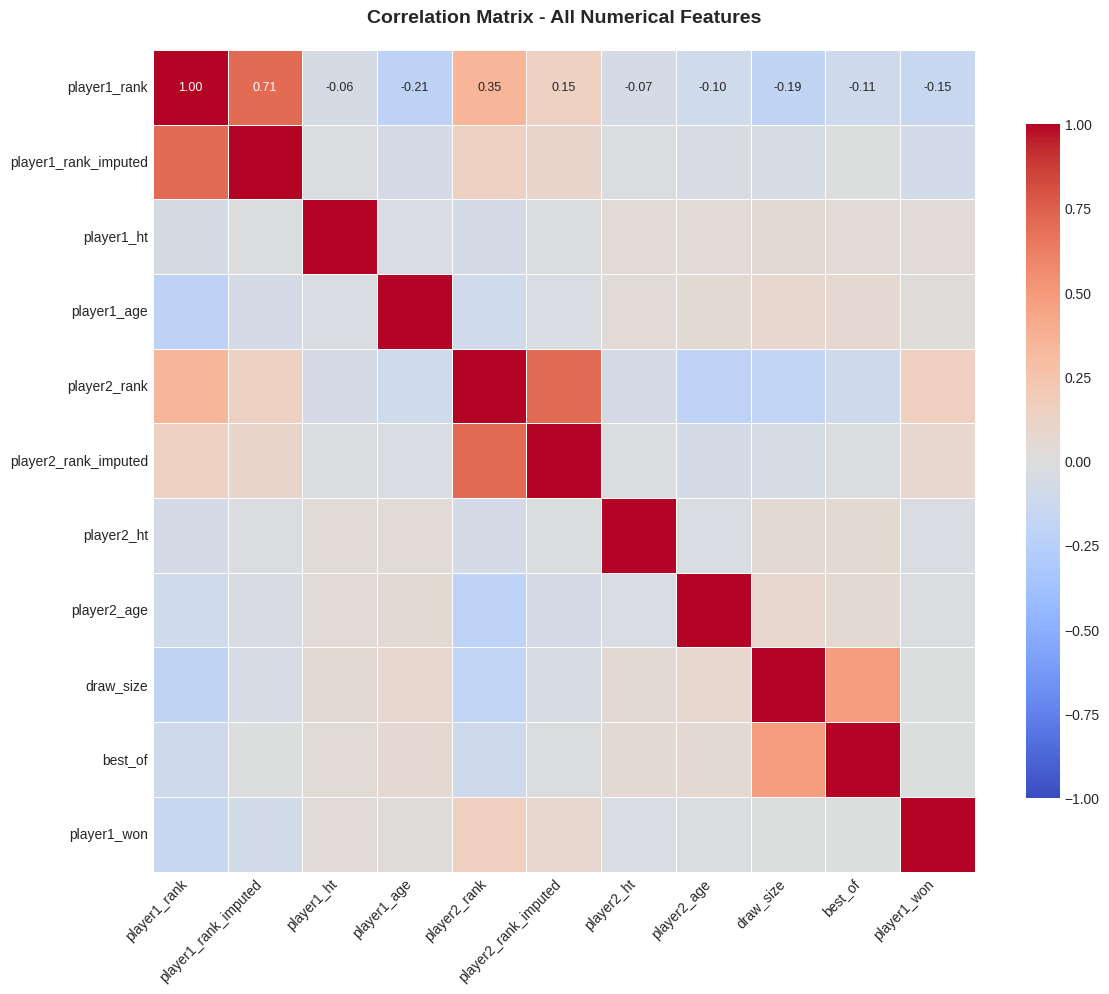

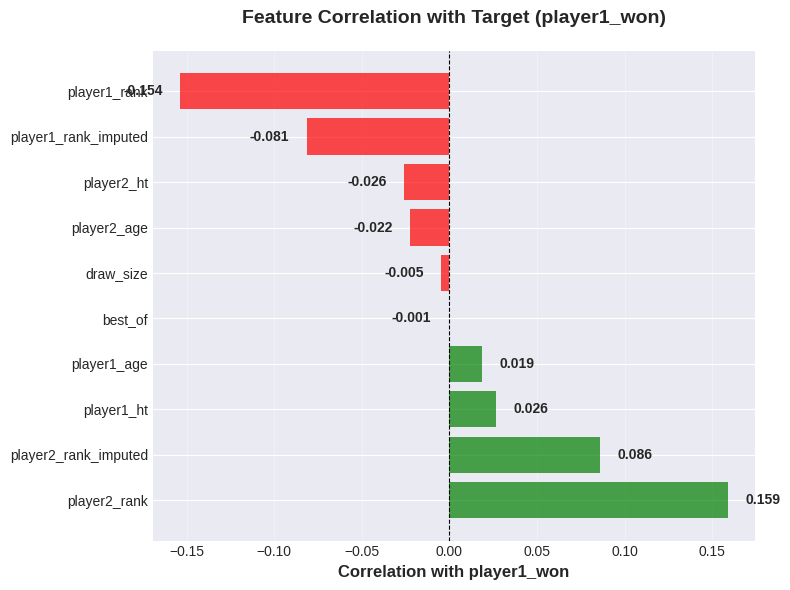


TOP CORRELATIONS WITH player1_won (NUMERICAL FEATURES)
player2_rank            0.158755
player2_rank_imputed    0.085919
player1_ht              0.026427
player1_age             0.018767
best_of                -0.000553
draw_size              -0.004640
player2_age            -0.022247
player2_ht             -0.025809
player1_rank_imputed   -0.081288
player1_rank           -0.153531


In [81]:
# Select only numerical columns (excluding IDs)
numerical_cols = [
    'player1_rank', 'player1_rank_imputed', 'player1_ht', 'player1_age',
    'player2_rank', 'player2_rank_imputed', 'player2_ht', 'player2_age',
    'draw_size', 'best_of', 'player1_won'
]

# Compute correlation matrix
corr_matrix = matches_final[numerical_cols].corr()

# ========= 1) FULL CORRELATION MATRIX HEATMAP =========
plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1, vmax=1,         # fixed color scale
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 9}
)

plt.title('Correlation Matrix - All Numerical Features',
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ========= 2) CORRELATIONS WITH THE TARGET ONLY =========
target_corr = corr_matrix['player1_won'].drop('player1_won').sort_values(ascending=False)
colors = ['green' if x > 0 else 'red' for x in target_corr.values]

plt.figure(figsize=(8, 6))
plt.barh(range(len(target_corr)), target_corr.values, color=colors, alpha=0.7)
plt.yticks(range(len(target_corr)), target_corr.index)
plt.xlabel('Correlation with player1_won', fontsize=12, fontweight='bold')
plt.title('Feature Correlation with Target (player1_won)',
          fontsize=14, fontweight='bold', pad=20)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)

# Add correlation values on bars
for i, v in enumerate(target_corr.values):
    plt.text(v + 0.01 if v > 0 else v - 0.01, i, f'{v:.3f}',
             va='center', ha='left' if v > 0 else 'right',
             fontweight='bold')

plt.tight_layout()
plt.show()

# Print top correlations
print("\n" + "="*70)
print("TOP CORRELATIONS WITH player1_won (NUMERICAL FEATURES)")
print("="*70)
print(target_corr.to_string())

## E. Feature Encoding categorical to numerical 

1. Encode Categorical Variables

* Why drop_first=True? - Because we'll get two columns for surface if there are 3 values and if both the 2 columns are 0 then its obiously the 3rd value ( Avoids multicollinearity i.e perfect correlation between the features )
* One thing to think about maybe drop the Countries because that is adding alot of features 

In [82]:
categorical_cols = [
    'player1_hand',      # R, L, U (Right, Left, Unknown)
    'player2_hand',      # R, L, U
    #'player1_ioc',       # Country codes (USA, ESP, FRA, etc.) - ~150 unique
    #'player2_ioc',       # Country codes
    'player1_entry',     # Direct, Q, WC, LL, etc.
    'player2_entry',     # Direct, Q, WC, LL, etc.
    'surface',           # Hard, Clay, Grass, Carpet
    'tourney_level',     # G, M, A, etc.
    'round',             # F, SF, QF, R16, R32, etc.
]

# One-hot encode (drop_first=True to avoid multicollinearity)
matches_encoded = pd.get_dummies(matches_final, columns=categorical_cols, drop_first=True)

print(f"Original columns: {len(matches_final.columns)}")
print(f"After encoding: {len(matches_encoded.columns)}")
print(f"Original shape: {matches_final.shape}")
print(f"Encoded shape: {matches_encoded.shape}")

# Keeping the Player context atm for feature engineering 
matches_encoded.to_csv('../data/processed/matches_final_with_player_context.csv', index=False)



Original columns: 24
After encoding: 86
Original shape: (161807, 24)
Encoded shape: (161807, 86)


### Running Mutual Information to see any relationship between features linear or non linear between features and label

* Note correlation matrix only captures linear relationships so we need to do this



## Results:



Current columns:
['player1_id', 'player1_name', 'player1_rank', 'player1_rank_imputed', 'player1_ht', 'player1_age', 'player2_id', 'player2_name', 'player2_rank', 'player2_rank_imputed', 'player2_ht', 'player2_age', 'player1_won', 'draw_size', 'tourney_date', 'best_of', 'Qualifying_match', 'player1_hand_L', 'player1_hand_R', 'player1_hand_U', 'player2_hand_L', 'player2_hand_R', 'player2_hand_U', 'player1_entry_2) A', 'player1_entry_3)', 'player1_entry_5) A', 'player1_entry_6)', 'player1_entry_6) A', 'player1_entry_8)', 'player1_entry_A', 'player1_entry_AL', 'player1_entry_ALT', 'player1_entry_Alt', 'player1_entry_Direct', 'player1_entry_I', 'player1_entry_ITF', 'player1_entry_J', 'player1_entry_LL', 'player1_entry_P', 'player1_entry_PR', 'player1_entry_Q', 'player1_entry_S', 'player1_entry_SE', 'player1_entry_UP', 'player1_entry_W', 'player1_entry_WC', 'player2_entry_2) A', 'player2_entry_3)', 'player2_entry_6)', 'player2_entry_6) A', 'player2_entry_A', 'player2_entry_AL', 'player2_ent

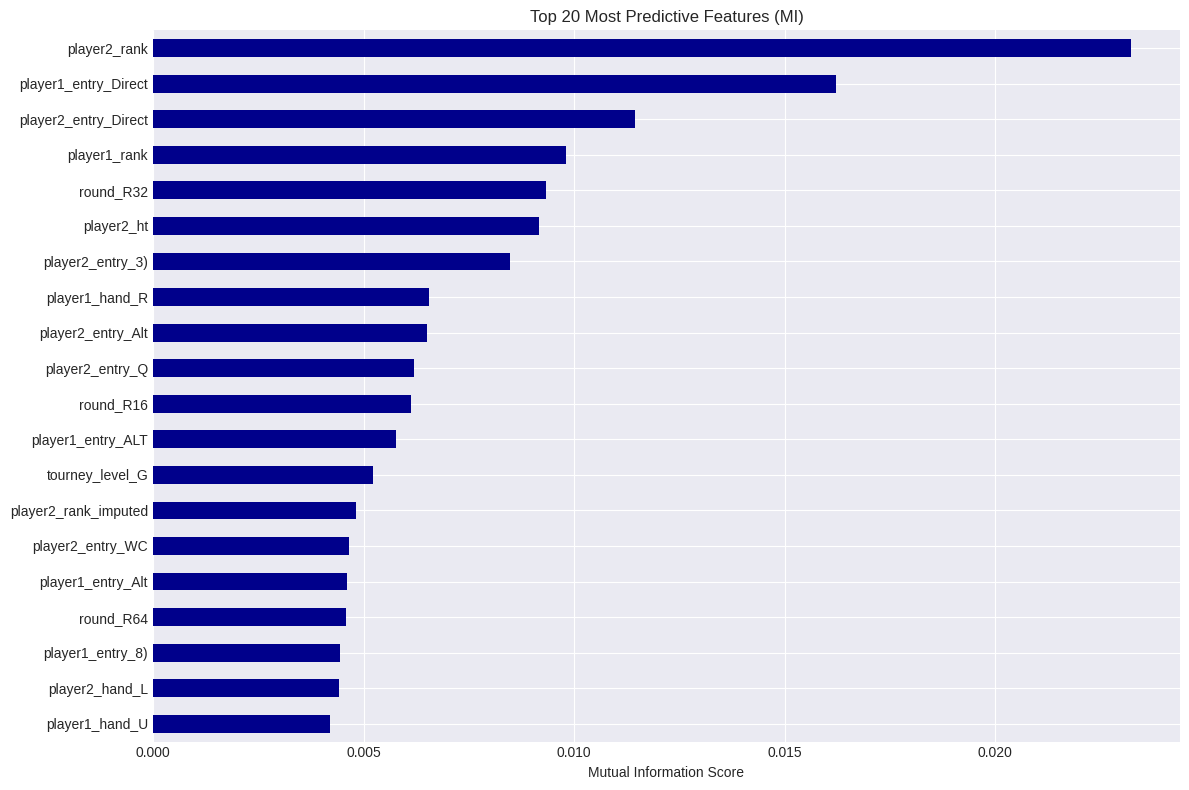


AGGREGATED MI SCORES (Original Features):
player1_entry           0.049481
player2_entry           0.045597
player2_rank            0.023226
round                   0.020326
player1_hand            0.011730
player2_hand            0.010543
tourney_level           0.010224
player1_rank            0.009801
player2_ht              0.009162
player2_rank_imputed    0.004822
player2_age             0.003524
player1_ht              0.001457
player1_rank_imputed    0.000550
player1_age             0.000000
surface                 0.000000
draw_size               0.000000
tourney_date            0.000000
Qualifying_match        0.000000
best_of                 0.000000
dtype: float64


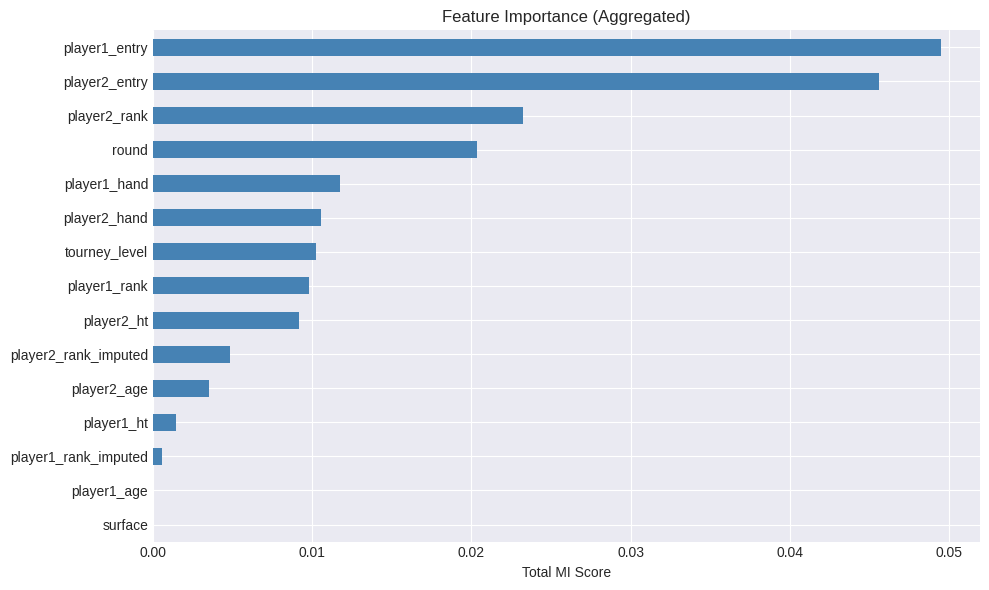

In [83]:
# Cell: Mutual Information (Fixed)
from sklearn.feature_selection import mutual_info_classif

# First, check what columns we have
print("Current columns:")
print(matches_encoded.columns.tolist())
print(f"\nData types:")
print(matches_encoded.dtypes)

# Drop ALL non-numeric columns
# This includes player names, IDs, etc.
X_clean = matches_encoded.drop(['player1_id', 'player2_id', 'player1_name', 'player2_name'], axis=1)

# Remove target
X = X_clean.drop('player1_won', axis=1)
y = matches_encoded['player1_won']

print(f"\nAfter cleaning:")
print(f"Features: {X.shape[1]}")
print(f"Rows: {X.shape[0]}")

# Sample for speed
sample_size = 16000
sample_indices = np.random.choice(len(X), sample_size, replace=False)

X_sample = X.iloc[sample_indices]
y_sample = y.iloc[sample_indices]

print(f"\nComputing MI on {len(X_sample):,} samples...")

# Compute MI
mi_scores = mutual_info_classif(X_sample, y_sample, random_state=42, n_jobs=-1)
mi_results = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("\nTOP 30 FEATURES BY MUTUAL INFORMATION:")
print(mi_results.head(30))

# Visualize
plt.figure(figsize=(12, 8))
mi_results.head(20).plot(kind='barh', color='darkblue')
plt.xlabel('Mutual Information Score')
plt.title('Top 20 Most Predictive Features (MI)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Aggregate one-hot encoded MI scores back to original features
aggregated_mi = {}

for feature, score in mi_results.items():
    # Determine base feature name
    if feature.startswith('player1_hand_'):
        base = 'player1_hand'
    elif feature.startswith('player2_hand_'):
        base = 'player2_hand'
    elif feature.startswith('player1_entry_'):
        base = 'player1_entry'
    elif feature.startswith('player2_entry_'):
        base = 'player2_entry'
    elif feature.startswith('surface_'):
        base = 'surface'
    elif feature.startswith('tourney_level_'):
        base = 'tourney_level'
    elif feature.startswith('round_'):
        base = 'round'
    else:
        base = feature  # Keep as is (rank, age, etc.)
    
    # Sum MI scores for each base feature
    if base not in aggregated_mi:
        aggregated_mi[base] = 0
    aggregated_mi[base] += score

# Sort and display
aggregated_mi = pd.Series(aggregated_mi).sort_values(ascending=False)

print("\nAGGREGATED MI SCORES (Original Features):")
print("="*60)
print(aggregated_mi)

# Plot
plt.figure(figsize=(10, 6))
aggregated_mi.head(15).plot(kind='barh', color='steelblue')
plt.xlabel('Total MI Score')
plt.title('Feature Importance (Aggregated)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## D. Removing the Identifying features 

* Required for model training ( technically should be a part of feature engineering at the end but right now doing it for model training)

In [84]:

# Drop ID and name columns (ignore if already dropped)
cols_to_drop = ['player1_id', 'player2_id', 'player1_name', 'player2_name']
matches_encoded = matches_encoded.drop(columns=cols_to_drop, errors='ignore')

print(matches_encoded.shape)

matches_encoded.to_csv('../data/processed/matches_final_without_player_context.csv', index=False)



(161807, 82)


# Plotting Data